# Assessments across interventions

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
os.makedirs('../figs', exist_ok=True)
import sys
sys.path.append('../code')
from data_cleaning import gender_mapping

plt.style.use('ggplot')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

In [3]:
query = """

WITH address_match AS (
  SELECT 
    a.person_id,
    a.assessmentid,
    ah.SOA as LSOA
  FROM 
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments` a
  LEFT JOIN 
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_Person_Address_History` ah
    ON a.person_id = ah.person_id
  QUALIFY ROW_NUMBER() OVER(PARTITION BY a.person_id, a.AssessmentID 
                           ORDER BY ABS(TIMESTAMP_DIFF(a.StartDate, CAST(ah.DateEvent AS TIMESTAMP), DAY))) = 1
)

SELECT 
  a.person_id, 
  a.assessmentid, 
  f.category,
  f.subcategory,
  a.StartDate,
  addr.LSOA
FROM 
  `yhcr-prd-bradfor-bia-core.CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments` a
LEFT JOIN 
  `CB_2649.cb_FactorLookup` f
  ON a.factorid = f.factorid
LEFT JOIN
  address_match addr
  ON a.person_id = addr.person_id AND a.assessmentid = addr.AssessmentID
"""

# Load Query into Pandas Dataframe

In [4]:
df = pandas_gbq.read_gbq(query)

Downloading: 100%|██████████|


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41880 entries, 0 to 41879
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     41880 non-null  object             
 1   assessmentid  41880 non-null  Int64              
 2   category      41880 non-null  object             
 3   subcategory   25770 non-null  object             
 4   StartDate     41880 non-null  datetime64[us, UTC]
 5   LSOA          30515 non-null  object             
dtypes: Int64(1), datetime64[us, UTC](1), object(4)
memory usage: 2.0+ MB


In [6]:
# Sort by date (descending) so the most recent entry comes first
df_sorted = df.sort_values('StartDate', ascending=False)

# Keep the first occurrence of each assessment ID (the most recent one)
df_unique_assessments = df_sorted.drop_duplicates('assessmentid')

# Verify we have exactly 11,218 rows
print(f"Rows after selecting one entry per assessment: {len(df_unique_assessments)}")

# Create a pivot table with categories
# create a dummy column
df['dummy'] = 1

# Create a mapping from assessment ID to person_id and date
assessment_info = df_unique_assessments[['assessmentid', 'person_id', 'StartDate', 'LSOA']]

# Create the pivot table with just assessment ID and categories
df_categories = pd.pivot_table(
    df,
    index=['assessmentid'],
    columns='category',
    values='dummy',
    aggfunc='max',
    fill_value=0
).reset_index()

# Merge the assessment info back to get person_id and date
df_wide = pd.merge(
    assessment_info,
    df_categories,
    on='assessmentid',
    how='left'
)
# Verify we have exactly 11,218 rows
print(f"Final rows in wide format: {len(df_wide)}")

Rows after selecting one entry per assessment: 11218
Final rows in wide format: 11218


In [7]:
# Calculate patterns per case
reasons_per_case = df_wide.iloc[:, 4:].sum(axis=1)  # excluding ids, date, and LSOA

# Calculate percentages and counts
total_cases = len(reasons_per_case)
single_reason_count = (reasons_per_case == 1).sum()
multiple_reasons_count = (reasons_per_case > 1).sum()

single_reason_percent = (single_reason_count / total_cases) * 100
multiple_reasons_percent = (multiple_reasons_count / total_cases) * 100

print("=== Entry Pattern Analysis ===")
print(f"Total number of cases: {total_cases}")
print(f"Cases with single reason: {single_reason_count} ({single_reason_percent:.1f}%)")
print(f"Cases with multiple reasons: {multiple_reasons_count} ({multiple_reasons_percent:.1f}%)")
print(f"Average number of reasons per case: {reasons_per_case.mean():.2f}")

# Further breakdown
print("\nDistribution of number of reasons:")
reason_distribution = reasons_per_case.value_counts().sort_index()
for n_reasons, count in reason_distribution.items():
    percentage = (count / total_cases) * 100
    print(f"{n_reasons} reason(s): {count} cases ({percentage:.1f}%)")

=== Entry Pattern Analysis ===
Total number of cases: 11218
Cases with single reason: 2671 (23.8%)
Cases with multiple reasons: 8547 (76.2%)
Average number of reasons per case: 3.19

Distribution of number of reasons:
1 reason(s): 2671 cases (23.8%)
2 reason(s): 2456 cases (21.9%)
3 reason(s): 1929 cases (17.2%)
4 reason(s): 1580 cases (14.1%)
5 reason(s): 1068 cases (9.5%)
6 reason(s): 674 cases (6.0%)
7 reason(s): 434 cases (3.9%)
8 reason(s): 200 cases (1.8%)
9 reason(s): 95 cases (0.8%)
10 reason(s): 46 cases (0.4%)
11 reason(s): 45 cases (0.4%)
12 reason(s): 6 cases (0.1%)
13 reason(s): 4 cases (0.0%)
14 reason(s): 8 cases (0.1%)
15 reason(s): 1 cases (0.0%)
20 reason(s): 1 cases (0.0%)


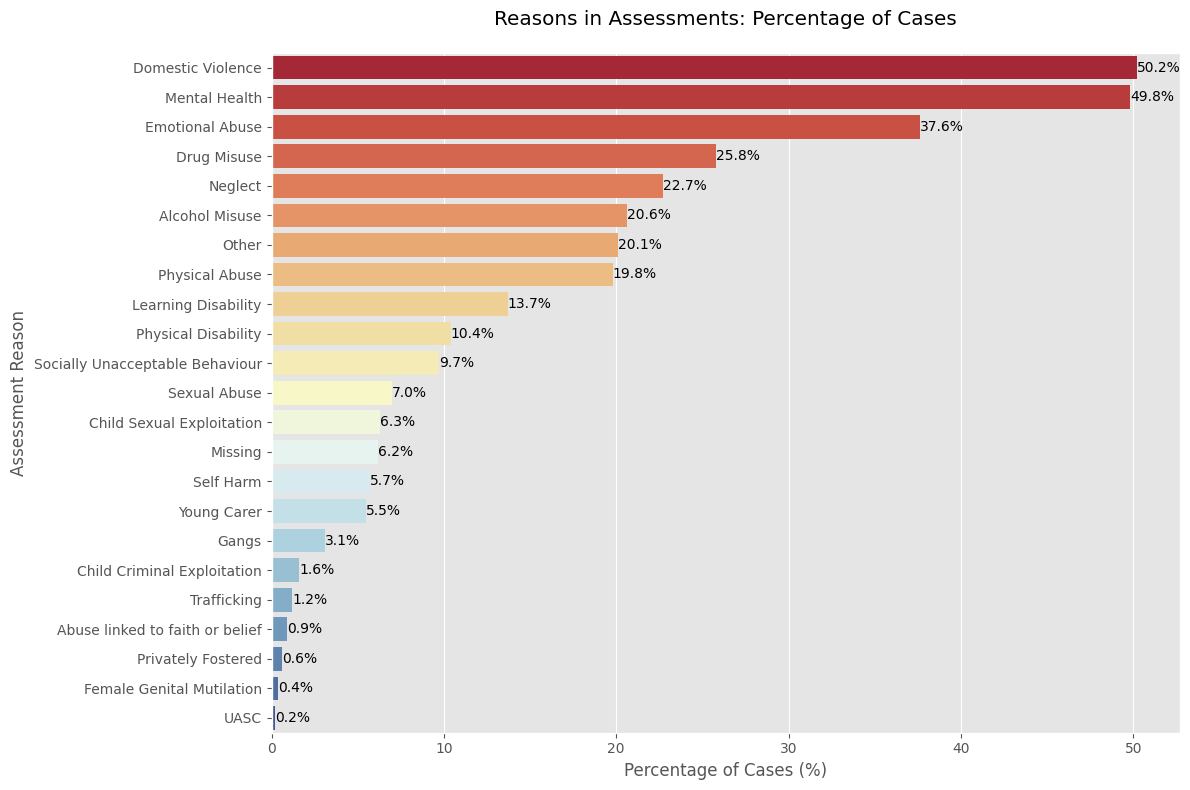

In [8]:
# Sum up each category column and sort in descending order
category_counts = df_wide.iloc[:, 4:].sum().sort_values(ascending=False)

# Calculate percentages
category_percentages = (category_counts / total_cases * 100)

# Combine counts and percentages in a readable format
category_analysis = pd.DataFrame({
    'Count': category_counts,
    'Percentage': category_percentages
}).round(1)  # Round percentages to 1 decimal place

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(
    x=category_analysis['Percentage'],
    y=category_analysis.index,
    palette='RdYlBu'  
)

plt.title('Reasons in Assessments: Percentage of Cases', pad=20)
plt.xlabel('Percentage of Cases (%)')
plt.ylabel('Assessment Reason')
# Add percentage labels on bars
for i, v in enumerate(category_analysis['Percentage']):
    plt.text(v, i, f'{v}%', va='center')
plt.tight_layout()
# plt.savefig(f'../figs/assessment_reason.png', dpi=300)
plt.show()

In [9]:
# Find most common reason combinations
# Create co-occurrence matrix
co_occurrence = df_wide.iloc[:, 4:].T.dot(df_wide.iloc[:, 4:])

# Find most common combinations
combinations = []
for i in range(len(co_occurrence)):
    for j in range(i+1, len(co_occurrence)):
        combinations.append({
            'reason1': co_occurrence.index[i],
            'reason2': co_occurrence.index[j],
            'count': co_occurrence.iloc[i,j]
        })

combinations_df = pd.DataFrame(combinations)
print("\n=== Most Common Reason Combinations ===")
print(combinations_df.sort_values('count', ascending=False).head(10).reset_index(drop=True))


=== Most Common Reason Combinations ===
             reason1            reason2  count
0  Domestic Violence      Mental Health   3019
1  Domestic Violence    Emotional Abuse   2876
2    Emotional Abuse      Mental Health   2681
3        Drug Misuse      Mental Health   1847
4  Domestic Violence        Drug Misuse   1800
5    Emotional Abuse     Physical Abuse   1682
6     Alcohol Misuse  Domestic Violence   1636
7    Emotional Abuse            Neglect   1620
8      Mental Health            Neglect   1589
9  Domestic Violence     Physical Abuse   1443


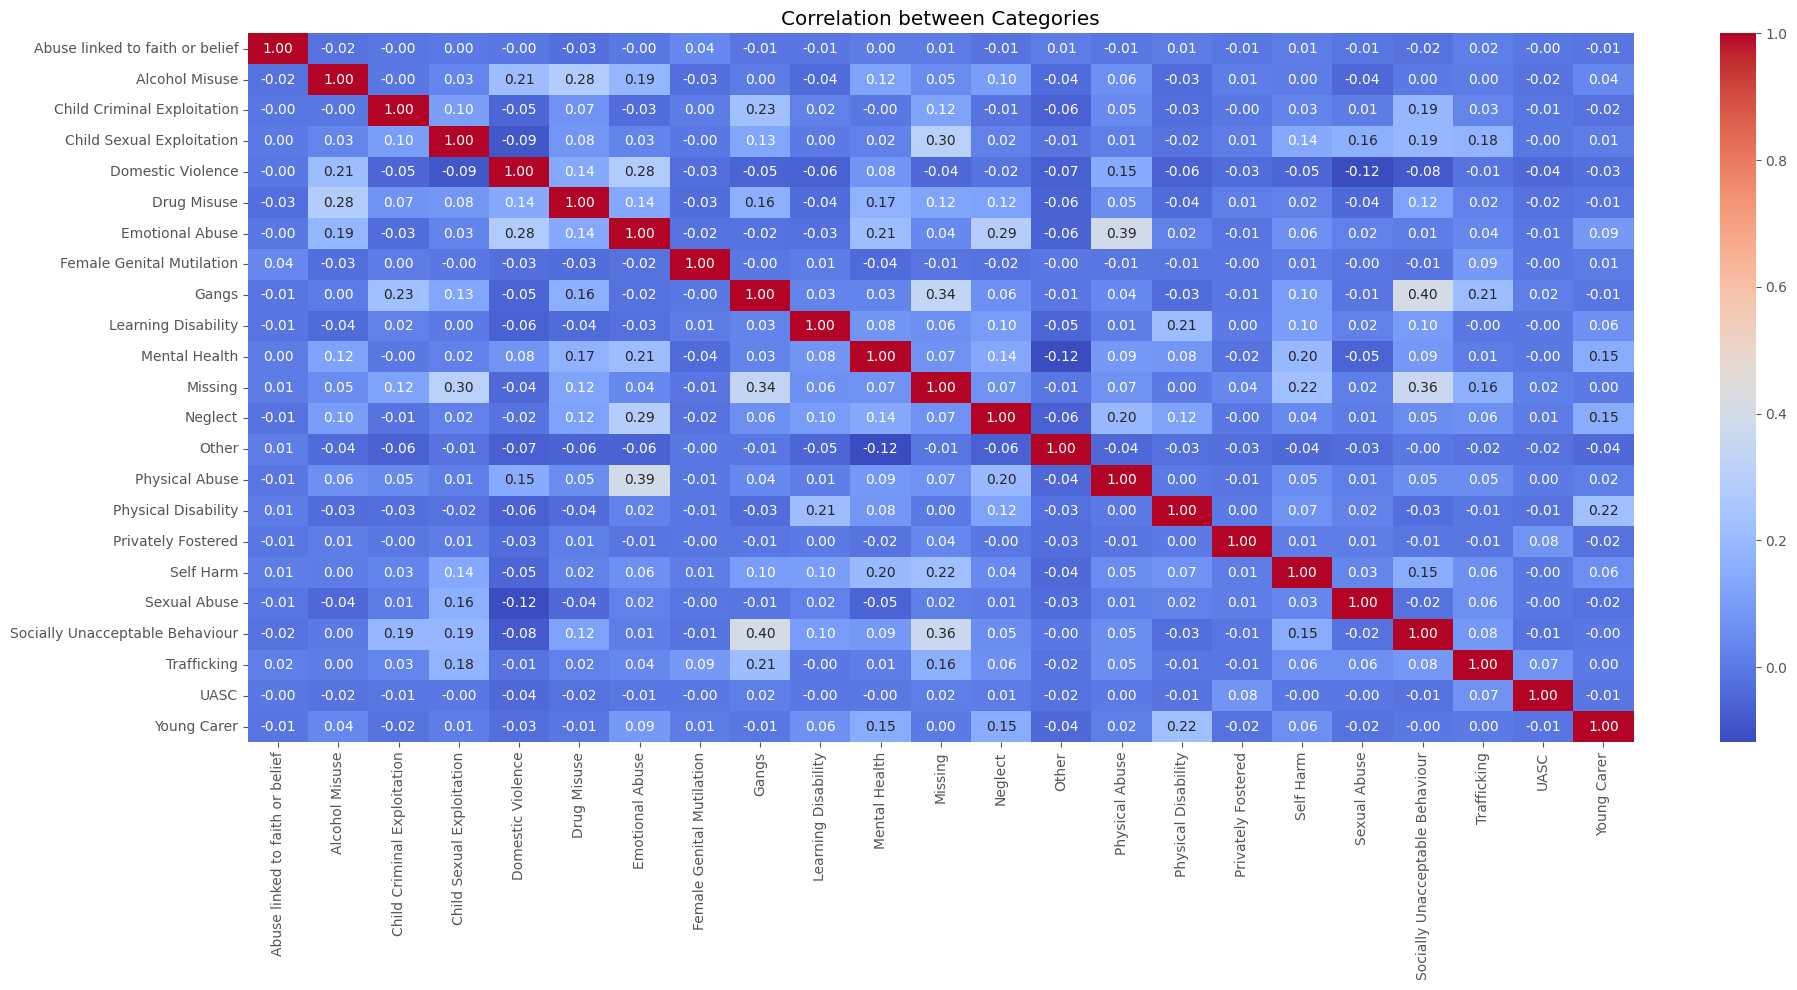

In [10]:
# Correlation between categories
plt.figure(figsize=(20,10))
correlations = df_wide.iloc[:, 4:].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Categories")
plt.tight_layout()
plt.show()

In [11]:
# Example of unique LSOA prefixes
df_wide['lsoa_prefix'] = df_wide['LSOA'].str[:3]
print(df_wide['lsoa_prefix'].unique())

['E01' None '' 'W01' 'S01']


In [12]:
# Filter to keep only English LSOAs (starting with 'E01') and remove empty strings
assessment_with_lsoa = df_wide[df_wide['LSOA'].str.startswith('E01', na=False)].drop(columns='lsoa_prefix')

# Assessments without LSOA and empty strings
assessments_without_lsoa = df_wide.loc[(df_wide['LSOA'].isnull()) | (df_wide['LSOA'] == '')].drop(columns='lsoa_prefix')

## Create Percentage of cases plot for assessments with and without LSOA

<Figure size 1400x1000 with 0 Axes>

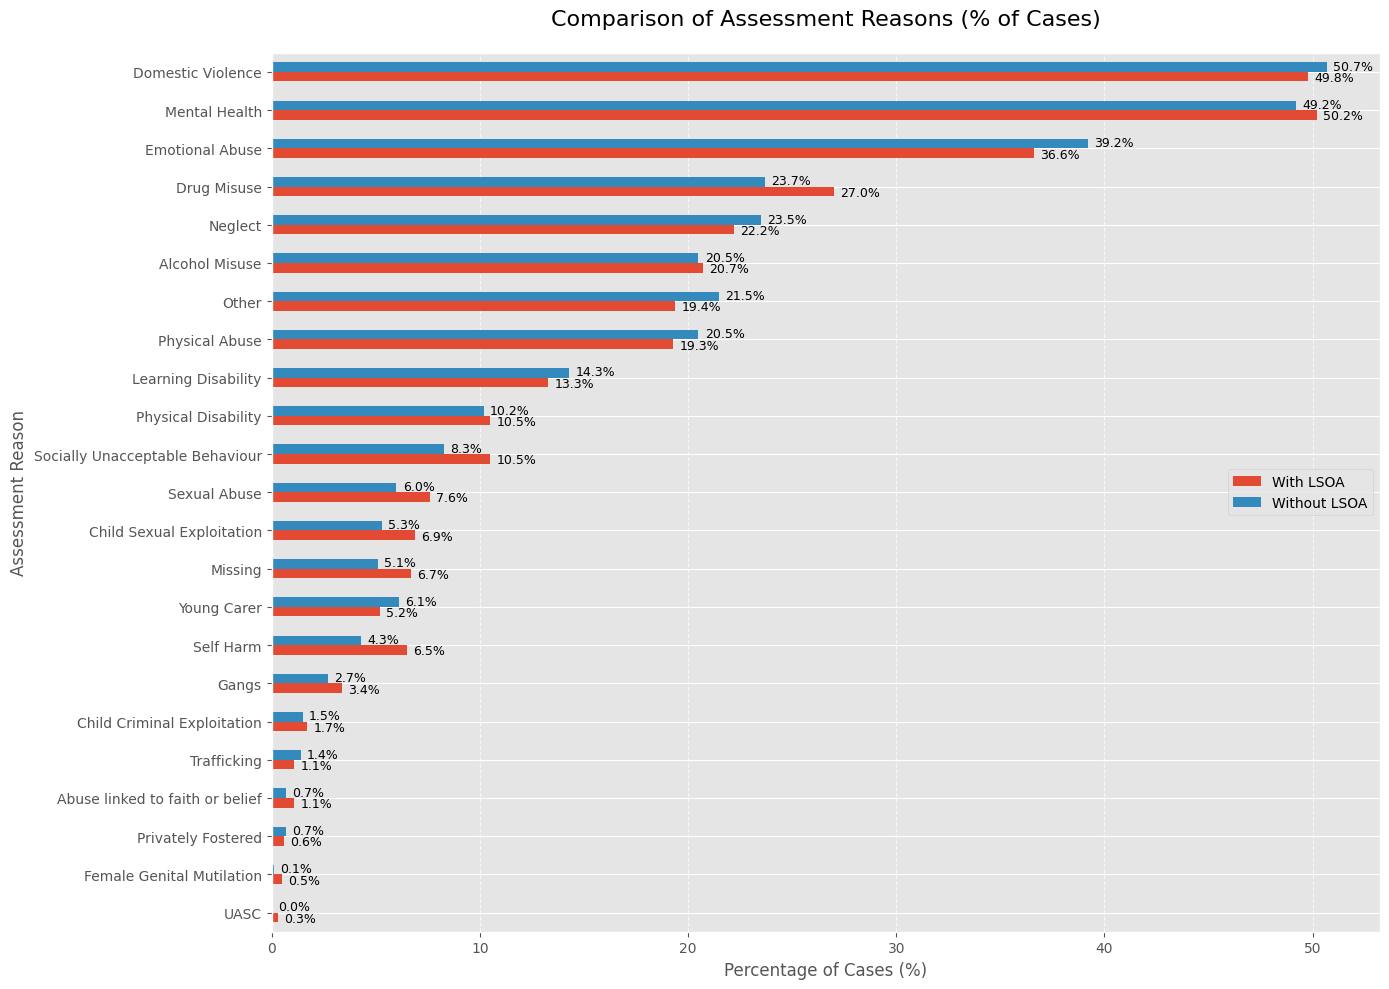

In [13]:
# Combine the two dataframes for easy comaprison

# Calculate percentages for with LSOA
total_with = len(assessment_with_lsoa.iloc[:, 4:])
counts_with = assessment_with_lsoa.iloc[:, 4:].sum().sort_values(ascending=False)
percentages_with = (counts_with / total_with * 100).round(1)
df_with = pd.DataFrame({'Percentage': percentages_with})

# Calculate percentages for without LSOA
total_without = len(assessments_without_lsoa.iloc[:, 4:])
counts_without = assessments_without_lsoa.iloc[:, 4:].sum().sort_values(ascending=False)
percentages_without = (counts_without / total_without * 100).round(1)
df_without = pd.DataFrame({'Percentage': percentages_without})

# Merge the data for comparison
comparison = pd.DataFrame({
    'With LSOA': percentages_with,
    'Without LSOA': percentages_without
})

# Sort by the average of both columns to maintain consistent ordering
comparison = comparison.reindex(comparison.mean(axis=1).sort_values(ascending=True).index)

# Plot side-by-side
plt.figure(figsize=(14, 10))
comparison.plot(kind='barh', figsize=(14, 10))
plt.title('Comparison of Assessment Reasons (% of Cases)', fontsize=16, pad=20)
plt.xlabel('Percentage of Cases (%)', fontsize=12)
plt.ylabel('Assessment Reason', fontsize=12)
plt.legend(loc='center right')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels with better positioning
for i, (with_val, without_val) in enumerate(zip(comparison['With LSOA'], comparison['Without LSOA'])):
    # Place labels at the end of each bar with consistent positioning
    plt.text(with_val + 0.3, i - 0.15, f'{with_val}%', va='center', fontsize=9)
    plt.text(without_val + 0.3, i + 0.15, f'{without_val}%', va='center', fontsize=9)
plt.tight_layout()
# plt.savefig(f'../figs/assessment_reason_compariosns.png', dpi=300)
plt.show()


Analyzing subcategories for: ['Domestic Violence', 'Mental Health']



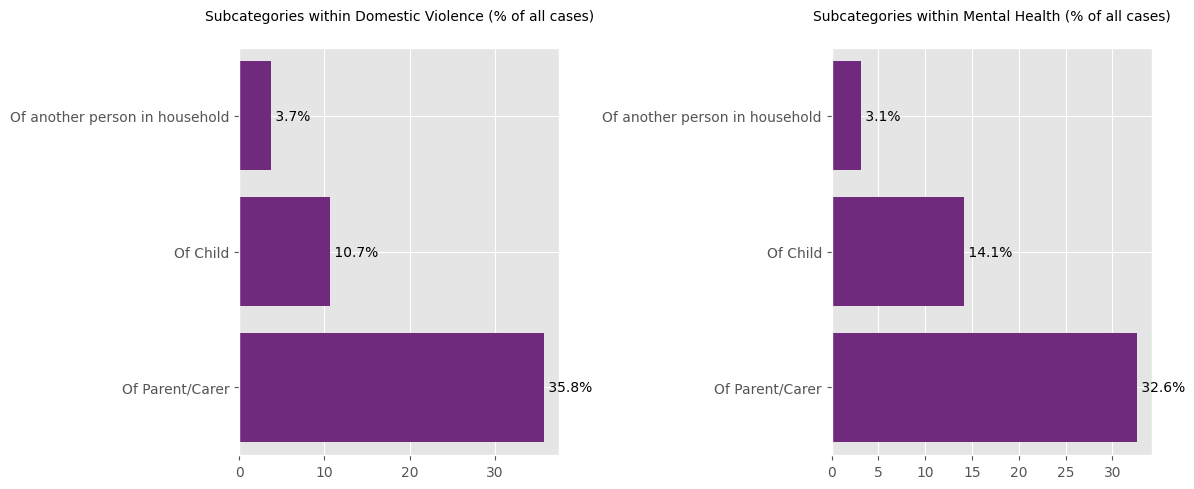

In [14]:
# Identify the top 2 categories
top_2_categories = category_analysis.head(2).index.tolist()
print(f"\nAnalyzing subcategories for: {top_2_categories}\n")

# Create a figure for subcategory analysis
plt.figure(figsize=(12, 5))

# For each top category, analyze its subcategories
for i, category in enumerate(top_2_categories):
    # get all assessment IDs that have this category
    category_assessments = df[df['category'] == category]['assessmentid'].unique()

    # create a dataframe with for each assessment
    # that has this category
    df_category_unique = df_sorted[
        (df_sorted['assessmentid'].isin(category_assessments)) &
        (df_sorted['category'] == category)
    ].drop_duplicates('assessmentid')

    # Now count subcategories from this filtered dataframe
    subcat_counts = df_category_unique['subcategory'].value_counts().drop([None], errors='ignore')

    # Calculate percentages relative to TOTAL cases
    subcat_percentages = (subcat_counts / total_cases * 100).round(1)

    # Create subplot
    ax = plt.subplot(1, 2, i+1)

    # Plot 
    bars = ax.barh(y=range(len(subcat_percentages)),
                  width=subcat_percentages.values,
                  color='#702A7D',
                  height=0.8)  

    # Set y-tick positions and labels
    ax.set_yticks(range(len(subcat_percentages)))
    ax.set_yticklabels(subcat_percentages.index)

    # Reduce space between bars by adjusting the y-axis limits
    if len(subcat_percentages) > 1:
        ax.set_ylim(-0.5, len(subcat_percentages) - 0.5)
    # Add percentage labels
    for j, (bar, percentage) in enumerate(zip(bars, subcat_percentages)):
        ax.text(percentage, j, f' {percentage}%', va='center')
    ax.set_title(f'Subcategories within {category} (% of all cases)', fontsize=10, pad=20)
plt.tight_layout()
# plt.savefig(f'../figs/top2_category_subcategory_plot.png', dpi=300)
plt.show()

### Monthly Count of Assessment & Unique Children having Assessment

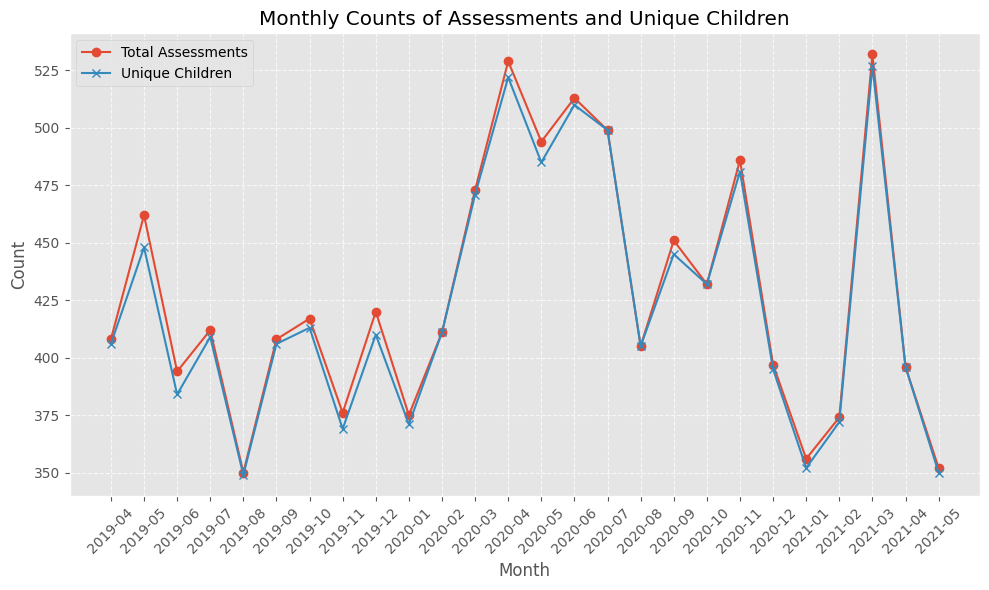

In [15]:
# Create month-year column
df_wide['month_year'] = df_wide['StartDate'].dt.strftime('%Y-%m')

# Calculate counts
monthly_assessments = df_wide.groupby('month_year').size().reset_index(name='assessment_count')
monthly_unique_children = df_wide.groupby('month_year')['person_id'].nunique().reset_index(name='unique_children_count')

# Merge results
monthly_counts = pd.merge(monthly_assessments, monthly_unique_children, on='month_year')

# Sort chronologically
monthly_counts['sort_date'] = pd.to_datetime(monthly_counts['month_year'] + '-01')
monthly_counts = monthly_counts.sort_values('sort_date')

# Remove the last month - the data is not for the complete month
monthly_counts = monthly_counts[:-1]

# Create visualization
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts['month_year'], monthly_counts['assessment_count'], 
         label='Total Assessments', marker='o')
plt.plot(monthly_counts['month_year'], monthly_counts['unique_children_count'], 
         label='Unique Children', marker='x')
plt.xticks(rotation=45)
plt.title('Monthly Counts of Assessments and Unique Children')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [16]:
monthly_assessments = monthly_assessments[:-1]
monthly_assessments.to_csv('monthly_assessments.csv', index=False)